In [ ]:
pip install -r requirements.txt

In [11]:
from options import Options
from grid import Grid
from trajectory_generator import generate_trajectory
import torch
import numpy as np
import plotting
import analysis
import os
%load_ext autoreload
import utils
import matplotlib.pyplot as plt
from train_RNN import TrainableNetwork, RNN_options, Trainer
%autoreload 2
from scipy.linalg import null_space
from tqdm import tqdm

SIM_PATH = os.getcwd() + '/sim_data/'

EXAMPLE_PATH = os.getcwd() + "/example_models/"  # Put interesting RNN of interest here
if not os.path.exists(EXAMPLE_PATH):
    os.mkdir(EXAMPLE_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Build and intiialize network

In [12]:
options = Options(lambda_net =  17)
options.dt= 5E-4
# options.n=128 # warning : large memory usage
options.n = 100
options.alpha=0.1

options.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device :', options.device)
grid = Grid(options)

device : cuda
Recovering pre-computed matrix found at /home/onyxia/work/grid_cells_burak_fiete/models/Wmat_beta=0.010380622837370242_gamma=0.011937716262975778_periodic=True_a=1.5_l=2_n=100.pth
Restoring pre-computed initial state found at /home/onyxia/work/grid_cells_burak_fiete/models/s0_beta=0.010380622837370242_gamma=0.011937716262975778_periodic=True_a=1.5_l=2_n=100_tau=0.01_alpha=0.1_tiling=deterministic_device=cuda_solver=euler_dt=0.0005.pth


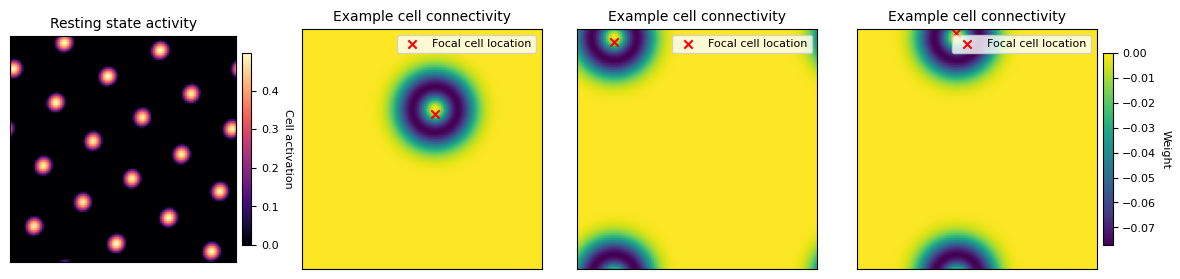

In [13]:
_ = plotting.network_presentation(grid)

In [14]:
# Collect fixed points : 

box_width = box_height = 2.2 # m 
T = 100 # s
dt = grid.options.dt
seq_len = int(T/dt)

traj = generate_trajectory(box_width, box_height, seq_len, dt=dt, load=True, batch_size = 1, save=True, silent=False)
input_v = traj['input_v'].squeeze()

pos = np.stack([traj['target_x'].squeeze(), traj['target_y'].squeeze()], 1)

grid.save_sim = False

S = grid.simulate(input_v, silent=False, load=True) # set load = false to restart a new sim from scratch


Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_batchsize=1_len=200000_dt=0.0005_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.45 GiB. GPU 0 has a total capacity of 14.57 GiB of which 6.93 GiB is free. Process 1956947 has 7.63 GiB memory in use. Of the allocated memory 391.27 MiB is allocated by PyTorch, and 7.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Simulating with Euler method


100%|██████████| 99/99 [00:02<00:00, 38.61it/s] 


Simulating with Euler method


100%|██████████| 99/99 [00:02<00:00, 38.06it/s] 


Simulating with Euler method


100%|██████████| 99/99 [00:02<00:00, 37.52it/s] 


Simulating with Euler method


100%|██████████| 99/99 [00:02<00:00, 37.25it/s] 


Simulating with Euler method


100%|██████████| 99/99 [00:02<00:00, 37.67it/s] 


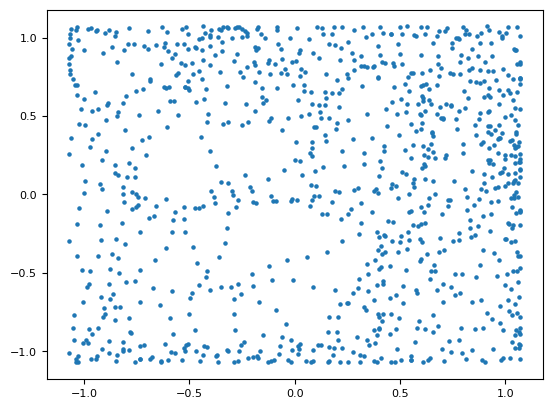

In [7]:
plt.scatter(*pos_sample.T, s= 5)

T = 0.05
seq_len = int(T/dt)

v = np.zeros((len(S_sample), seq_len, 2))

grid.save_sim = False
fixed_points = S_sample
for k in range(5) : # limit memory use 
    out = grid.simulate(v, s_0 = fixed_points, silent=False, load=False, ) # set load = false to restart a new sim from scratch
    fixed_points= out[:, -1].cpu()
    
del out

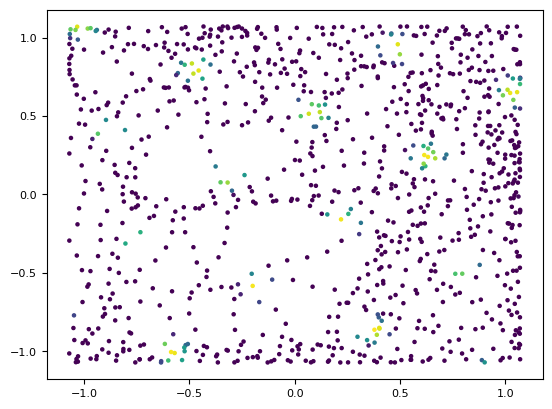

In [9]:
plt.scatter(*pos_sample.T, s= 5, c=fixed_points[:, 100])

In [ ]:
rate_map = 

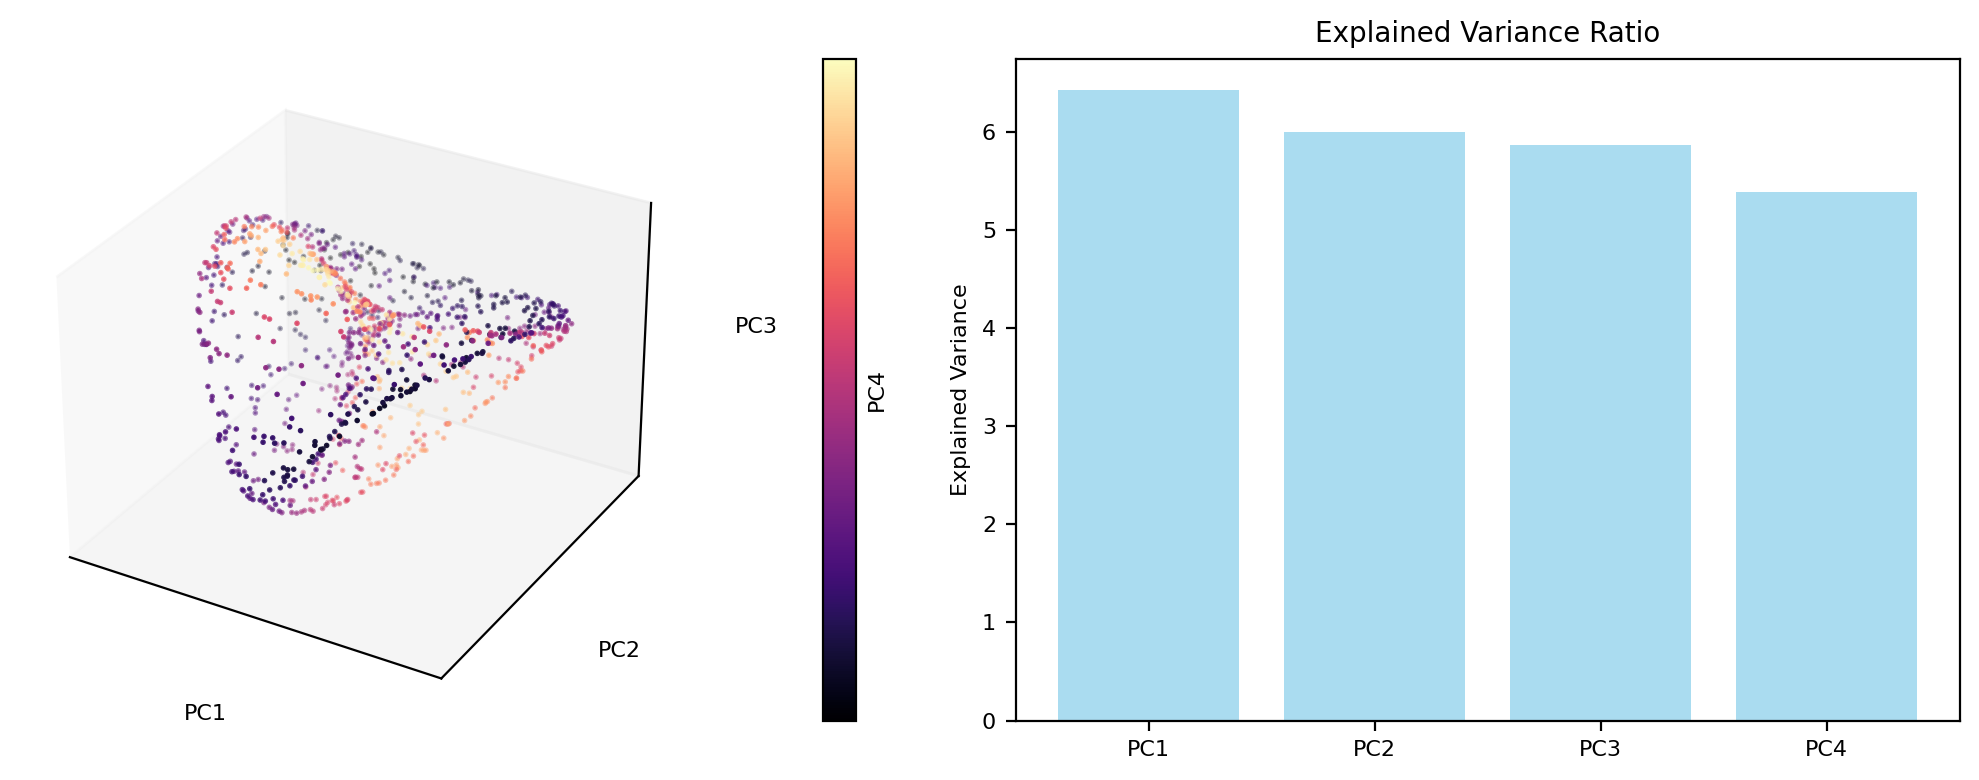

In [10]:
projected_data, explained_variance, components = analysis.pca_torch_gpu(fixed_points.to(options.device), num_components=6)

projected_data = projected_data.cpu().numpy()
fig = plt.figure(figsize=(10, 4), dpi=200)

ax = fig.add_subplot(121, projection='3d')
p = ax.scatter(xs=projected_data[:, 0].astype('float'),
               ys=projected_data[:, 1].astype('float'),
               zs=projected_data[:, 2].astype('float'),
               c=projected_data[:, 3].astype('float'),
               cmap=plt.cm.magma, s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

cbar = fig.colorbar(p, ax=ax, pad=0.15, label='PC4')
cbar.set_ticks([])

# Create bar plot for explained variance
ax2 = fig.add_subplot(122)
components = ['PC1', 'PC2', 'PC3', 'PC4']
ax2.bar(components, explained_variance[:4].cpu(), color='skyblue', alpha=0.7)
ax2.set_ylabel('Explained Variance')
#ax2.set_ylim(0, 1)
ax2.set_title('Explained Variance Ratio')

plt.tight_layout()
plt.show()

In [19]:
explained_variance

tensor([2.3286, 1.9488, 1.7682, 1.5904, 1.5040, 1.1518])

In [46]:
unit_v = np.array([np.cos(np.pi/3), np.sin(np.pi/3)])
unit_v

array([0.5      , 0.8660254])

In [48]:
unit_v @ pos_sample.T, np.exp(-unit_v@pos_sample.T) * fixed_points[:, 30].numpy()

(array([ 1.90607672e-01,  1.26551061e-01,  9.81715754e-02,  1.15963744e-01,
         1.64795904e-01,  2.24957037e-01,  2.86592867e-01,  3.67073682e-01,
         4.65912220e-01,  5.62413546e-01,  6.51895304e-01,  6.97069565e-01,
         7.19066077e-01,  7.43379572e-01,  8.27607471e-01,  8.39367381e-01,
         8.71837472e-01,  9.14022440e-01,  9.20667612e-01,  9.50826059e-01,
         1.01577823e+00,  1.04588006e+00,  1.06646223e+00,  1.11748598e+00,
         1.16031574e+00,  1.16487047e+00,  1.17975813e+00,  1.16472638e+00,
         1.12480524e+00,  1.11013603e+00,  1.04112317e+00,  1.00167572e+00,
         9.33815894e-01,  8.34182411e-01,  7.47026835e-01,  6.53446636e-01,
         6.18335957e-01,  5.94714544e-01,  5.19629798e-01,  4.42831022e-01,
         3.48211303e-01,  2.53922475e-01,  2.09725826e-01,  1.29957946e-01,
         4.76122120e-02, -3.33687535e-02, -1.32283453e-01, -2.21370223e-01,
        -3.14496191e-01, -4.11625778e-01, -4.99682469e-01, -5.94237043e-01,
        -6.3

In [ ]:
unit_v

In [44]:
# spatial_phases 

for theta in [0, 60, 120]:  
    k = np.array([np.cos(theta), np.sin(theta)])
    phase = np.sum(np.exp(-k@pos_sample.T)[:, None]  * fixed_points.numpy(), axis=0)

In [49]:
phase = phase/np.linalg.norm(phase)
phase

array([0.01271861, 0.01337623, 0.01394321, ..., 0.0124006 , 0.01160923,
       0.01063822], shape=(1600,))

In [34]:
(np.exp(k@pos_sample.T)[:, None]  * fixed_points.numpy()).shape

(1000, 1600)

In [25]:
pos_sample.T

array([[-0.04721374, -0.14932154, -0.2389815 , ...,  0.47703474,
         0.53933085,  0.63330956],
       [-0.18993103, -0.20765841, -0.17272731, ..., -0.00606927,
         0.06189963,  0.04141194]], shape=(2, 1000))

### 2. Integrate random trajectory

Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_len=20000_dt=0.0005_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it
Simulating with euler method


100%|██████████| 19999/19999 [02:24<00:00, 138.26it/s]


saving simulation at /home/onyxia/work/grid_cells_burak_fiete/sim_data/example_sim_T=10_dt=0.0005_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=128_tau=0.01_alpha=0.1_tiling=deterministic_device=cuda_solver=euler_dt=0.0005.pth
labeling blobs


100%|██████████| 20000/20000 [00:03<00:00, 6578.11it/s]


detected less than 43 blobs per frame
computing blob centers


/opt/conda/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|██████████| 20000/20000 [00:12<00:00, 1615.52it/s]


found 12 best blob jumps : interpolating speed between them
Estimated prediction to truth size ratio = 0.1223, R2=0.998


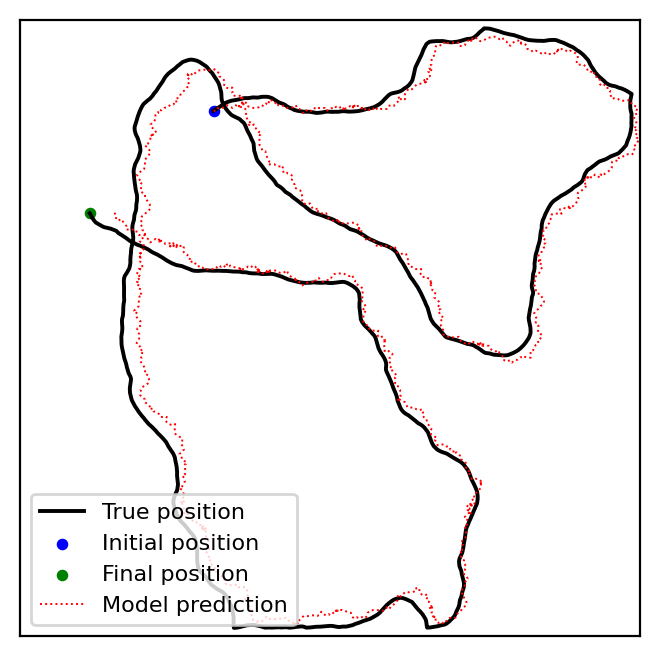

In [30]:
# generate a trajectory 
box_width = box_height = 2.2 # m 
T = 10 # s
dt = grid.options.dt
seq_len = int(T/dt)

traj = generate_trajectory(box_width, box_height, seq_len, dt=dt, load=True, save=True, batch_size = 1, silent=False)
input_v = traj['input_v'].squeeze()
pos = np.stack([traj['target_x'].squeeze(), traj['target_y'].squeeze()], 1)

fname = f"example_sim_T={T}_dt={dt}_{grid.grid_id}.pth"
grid.save_sim = True
S = grid.simulate(input_v, sim_id = fname, silent=False, load=True) # set load = false to restart a new sim from scratch

# downsample if needed for faster analysis 
# new_dt = 1E-3
# S = utils.downsample(S, new_dt=new_dt, old_dt = dt)
# pos = utils.downsample(pos, new_dt=new_dt, old_dt = dt)

pos_pred, prop_factor, r2 = analysis.model_prediction(S, pos, verb = True)

_ = plotting.compare_model_prediction(pos_pred, pos, box_width = box_width, box_height = box_height)

### Dim reduction

In [ ]:
## Fixed points
W = grid.W.cpu().numpy()
ker = null_space(np.eye(len(W))-W)

### Idées pour la suite :

- Entrainer un RNN (approche normative/optimale) cf https://github.com/ganguli-lab/grid-pattern-formation (publié sur Neuron, j'ai testé un peu l'approche et ca fonctionne, suffit de reprendre leur code ou de recoder une version + simple) => Comparer le résultat du RNN et du modele de burak

- Regarder la topologie du réseau (topologie torique ?) -> reduction de la dimensionalité de la matrice de connectivité et / ou de l'activité neuronale. Comparer eventuellement avec le RNN 

### 3. Normativity and optimisation : Train a RNN

We re-exploited recent work from [Sorscher *et al.* 2023](https://doi.org/10.1080/02786828708959166)

We adapted part of their [original code](https://github.com/ganguli-lab/grid-pattern-formation) for our simple use. In particular, grid cells patterns of activation were changed and new constraints were imposed to the model

In [46]:
rnn_opt = RNN_options()

rnn_opt.save_dir = os.getcwd() + '/models/'
rnn_opt.n_steps = 10000         # number of training steps
rnn_opt.batch_size = 200         # number of trajectories per batch
rnn_opt.sequence_length = 100     # number of steps in trajectory
rnn_opt.learning_rate = 1e-4     # gradient descent learning rate
rnn_opt.pc_sheet_size = 30      # sqrt of number of place cells 
rnn_opt.gc_sheet_size = 40       # sqrt of number of grid cells
rnn_opt.pc_sigma = 0.2

# width of place cell center tuning curve (m)
rnn_opt.activation = 'relu'      # recurrent nonlinearity
rnn_opt.weight_decay = 1e-4      # strength of weight decay on recurrent weights
rnn_opt.box_width = 2.2            # width of square arena 
rnn_opt.dt = 1E-2
rnn_opt.device = "cuda" if torch.cuda.is_available() else 'cpu'
rnn_opt.optim = 'adam'
rnn_opt.clip_grad = False
rnn_opt.debug = False

network = TrainableNetwork(rnn_opt,)
trainer = Trainer(network,  restore=True)

Restored trained model from /home/onyxia/work/grid_cells_burak_fiete/models/n_steps_10000_batch_size_200_sequence_length_100_learning_rate_0.0001_pc_sheet_size_30_gc_sheet_size_40_pc_sigma_0.2_activation_relu_weight_decay_0.0001_box_width_2.2_dt_0.01_optimizer_adam_device_cuda_clip_grad_False_optim_adam/most_recent_model.pth


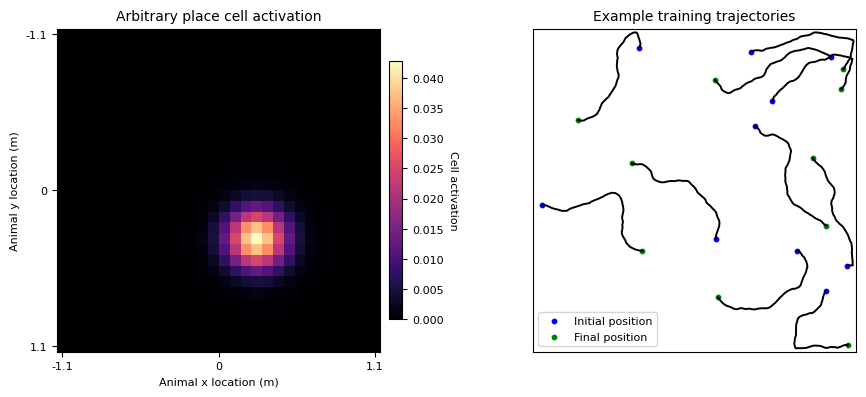

In [51]:
_ = plotting.present_training_environment(network, trainer, show=True)

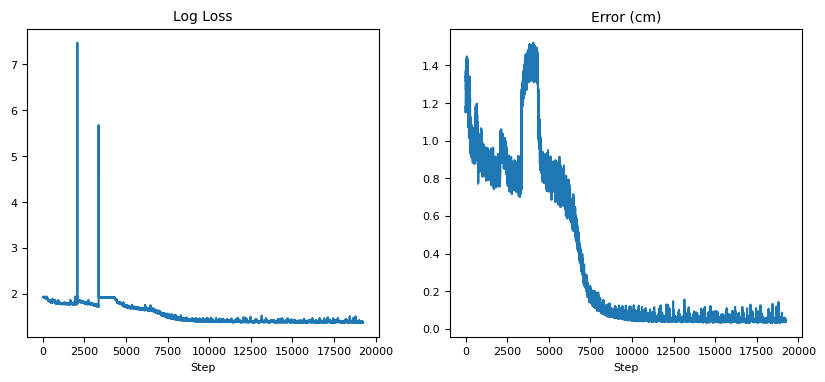

Epoch 1/2 step 9278 : Loss 3.96 Error =   3.5 cm:  93%|█████████▎| 9279/10000 [33:37<03:02,  3.94it/s]

In [ ]:
n_epochs = 2
# trainer.train(n_epochs, rnn_opt.n_steps, plot=True)

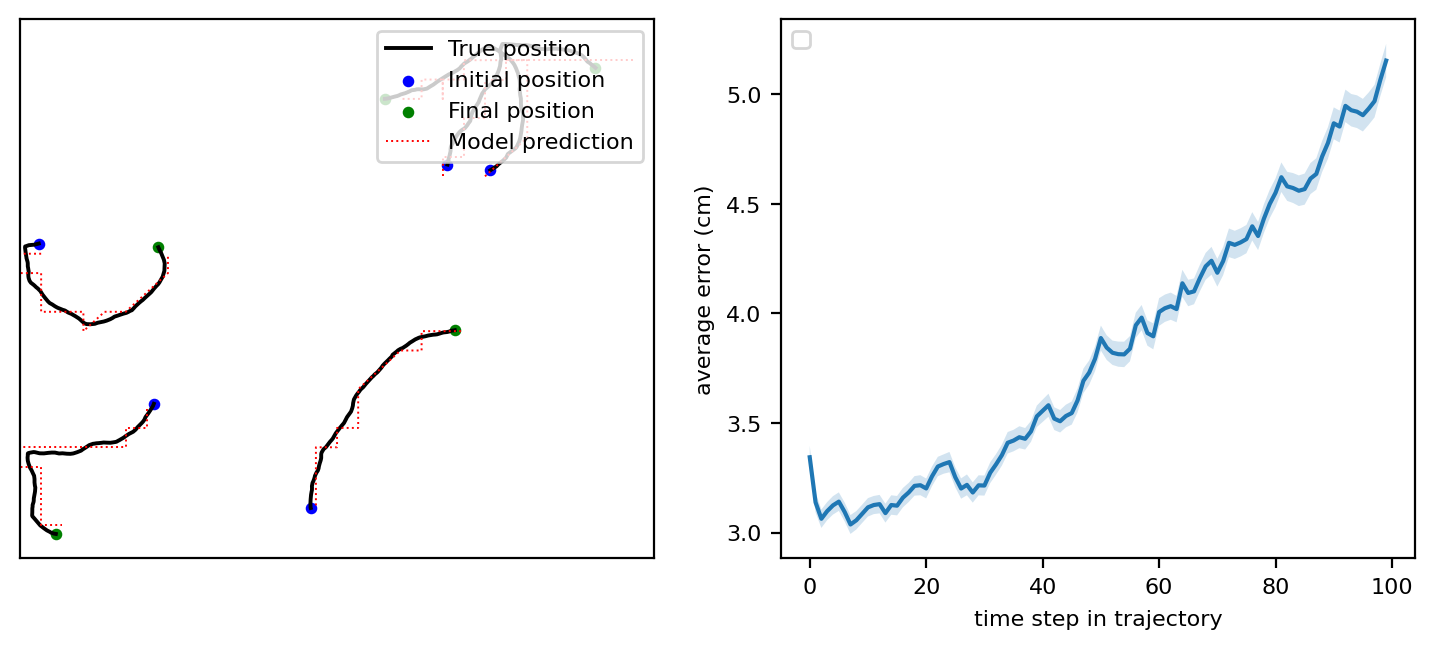

In [13]:
_ = plotting.show_training_results(trainer, network, sequence_length = 100, num_trajectories =1000, plotted_trajectories=5, show=True)

In [14]:
model_name = f"example_weight_decay={rnn_opt.weight_decay}_pc={rnn_opt.pc_sheet_size**2}_gc={rnn_opt.pc_sheet_size**2}_seqlen={rnn_opt.sequence_length}_no_other_reg.pth"

torch.save(network.state_dict(), EXAMPLE_PATH + model_name)

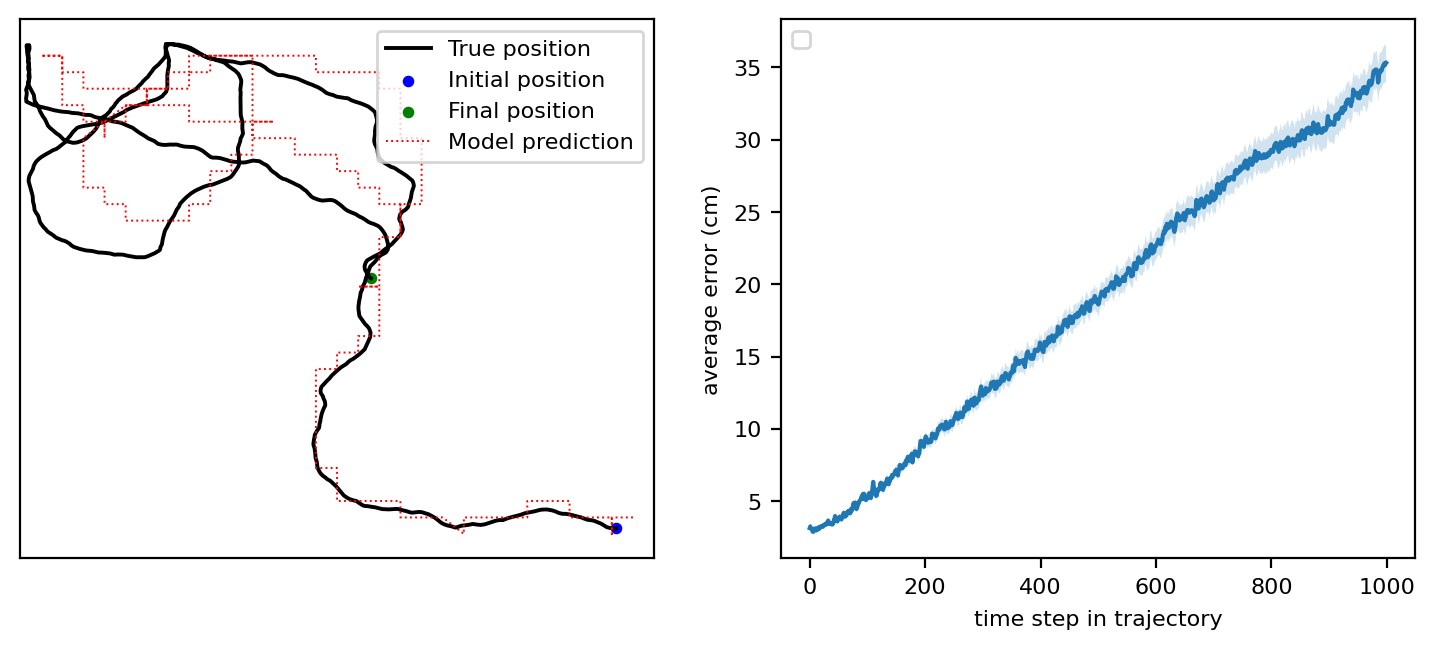

In [15]:
_ = plotting.show_training_results(trainer, network, show=True, sequence_length = 1000, plotted_trajectories = 1, num_trajectories = 100)

## 4. Evaluate performances of both approaches

In [ ]:
plt.plot(W_grid

# TODO :

### 1) Résultats principaux de l'article ->> Nicolas
- Faire une fonction qui montre le champ d'activation d'une grid cell, pour voir si l'activation est effectivement en grille
- Evaluer comment les erreurs se propagent au cours du temps cf figure 2 de l'article

### 2) RNN ->> Grégoire
- Voire si on peut améliorer la résolution spatiale des place cells
- Voire si on peut augmenter la taille de la séquence ( très courte pour l'instant et tester le modèle sur une grosse séquence )
- Utiliser les fonctions du **1)** pour evaluer le RNN - > comparer les modèles
- Ajouter des contraintes supplémentaires (contraintes sur l'activité "energetiques" en plus des contraintes sur les poids

### 3) Possibles suites
- Projection de l'activité des cellules dans un espace a faible dimension pour les deux réseaux -> voire les projections présentées dans la littérature
- Comparaison de la connectivité des cellules entre RNN et Burak-> Grégoire se renseigne la dessus
- Ondes theta et phase precession -> Nicolas si il a le temps

#### Avec ca on est très large en terme de contenu, largement au dessus des attentes du cours a mon avis ;)